In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_ae import *
import torch
import random
from pathlib import Path
from config import *
from utils import *

import numpy as np
import platform

architecture='lstm_ae'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture='lstm_ae')
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_sl_16
num selection:1 - exp name:4_wheel_system_01-24-23:13:40:52_extended_params_sl_100
num selection:2 - exp name:4_wheel_system_01-24-23:18:55:37_extended_params_sl_100_run_2
num selection:3 - exp name:third_wheel_01-24-23:11:20:34_extended_params_sl_100
num selection:4 - exp name:4_wheel_system_01-24-23:12:00:52_extended_params_sl_16


In [64]:
select_exp = '4'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_01-24-23:12:00:52_extended_params_sl_16


In [65]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /home/robertomorelli/time_series_anomaly_detection/model_results/esa_exploration/lstm_ae/4_wheel_system_01-24-23:12:00:52_extended_params_sl_16/summary.csv


In [71]:
summary.reset_index().head(10)

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,29,28,"trainLSTMAE_5e4a6_00020_20_batch_size=100,embe...",153912,0.010813,0.010222
1,28,12,"trainLSTMAE_5e4a6_00026_26_batch_size=100,embe...",153912,0.011068,0.010550
2,27,18,"trainLSTMAE_5e4a6_00013_13_batch_size=500,embe...",157132,0.018795,0.019338
3,26,21,"trainLSTMAE_5e4a6_00006_6_batch_size=500,embed...",157132,0.024790,0.025832
4,25,16,"trainLSTMAE_5e4a6_00003_3_batch_size=500,embed...",42168,0.070480,0.073543
5,24,22,"trainLSTMAE_5e4a6_00005_5_batch_size=500,embed...",153912,0.071262,0.076199
6,23,14,"trainLSTMAE_5e4a6_00000_0_batch_size=500,embed...",43788,0.097898,0.103799
7,22,29,"trainLSTMAE_5e4a6_00022_22_batch_size=500,embe...",153912,0.141904,0.145717
8,21,19,"trainLSTMAE_5e4a6_00029_29_batch_size=500,embe...",153912,0.141904,0.145717
9,20,8,"trainLSTMAE_5e4a6_00028_28_batch_size=100,embe...",43788,0.187971,0.201950


In [52]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
print(os.path.join(model_name_path))

trainLSTMAE_4efce_00004_4_batch_size=100,embedding_dim=32,epochs=200,latent_dim=80,lr=0.0006,lr_patience=5,n_layers_cell_1=2,n_lay_2023-01-24_18-56-59/checkpoint_000109/model.pt


In [53]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path))
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [54]:
if platform.node()=='leonard':
    device='cpu'
else:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

In [55]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=checkpoint['cfg']['dataset']['columns'],
columns_subset=cfg['dataset']['columns_subset'], dataset_subset=cfg['dataset']['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=cfg['dataset']['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)    


In [56]:
num_batch=1
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 100
random shift 17140


In [57]:
try:
    model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
            n_features=params_conf['n_features'], output_size=params_conf['output_size'],
            embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                    n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2'])
except:
    model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        n_features=params_conf['n_features'], output_size=params_conf['output_size'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                n_layers_1=params_conf['n_layers'], n_layers_2=params_conf['n_layers'])
model.load_state_dict(checkpoint['model_state_dict'])
print(model.to(device).eval())
print('parameters number', count_parameters(model))

LSTM_AE(
  (encoder): Encoder(
    (LSTMenc): LSTM(16, 64, num_layers=2, batch_first=True)
    (LSTM1): LSTM(64, 32, num_layers=2, batch_first=True)
    (enc): Linear(in_features=32, out_features=80, bias=True)
  )
  (decoder): Decoder(
    (LSTMdec): LSTM(80, 32, num_layers=2, batch_first=True)
    (LSTM1): LSTM(32, 64, num_layers=2, batch_first=True)
    (fc): Linear(in_features=64, out_features=16, bias=True)
  )
)
parameters number 160352


In [58]:
x, enc, yo = model(x.to(device))

In [59]:
path = './figure_results/{}/{}/'.format(model_results_path, shift)
par_nums=count_parameters(model)
print(path)
save = False

./figure_results//home/robertomorelli/time_series_anomaly_detection/model_results/esa_exploration/lstm_ae/4_wheel_system_01-24-23:18:55:37_extended_params_sl_100_run_2/17140/


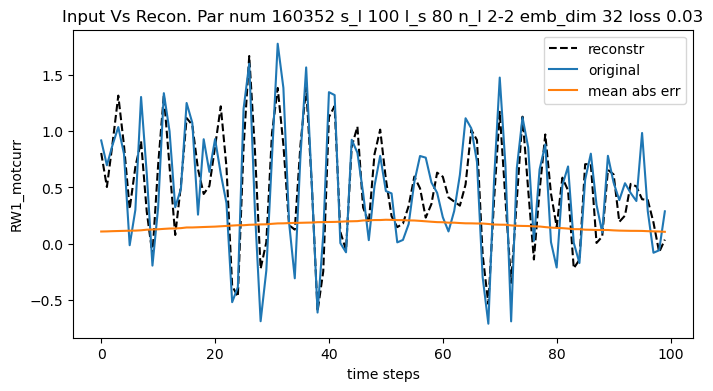

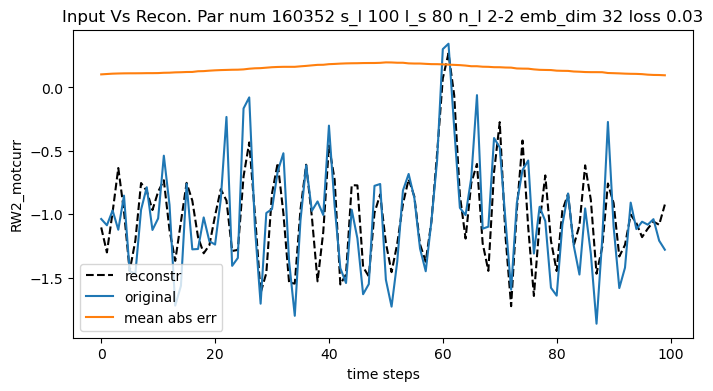

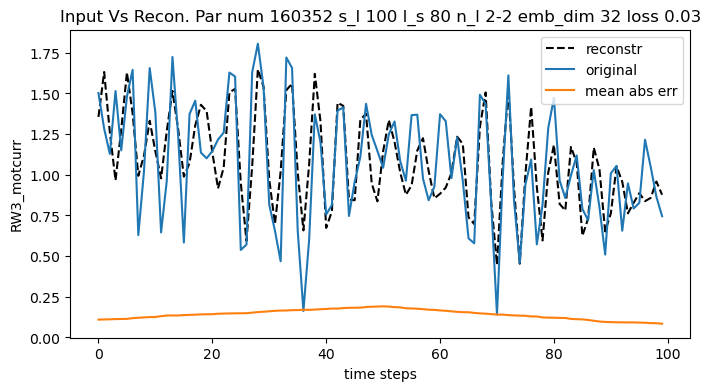

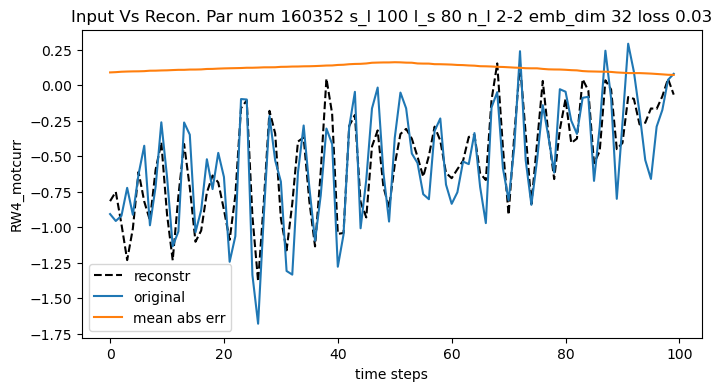

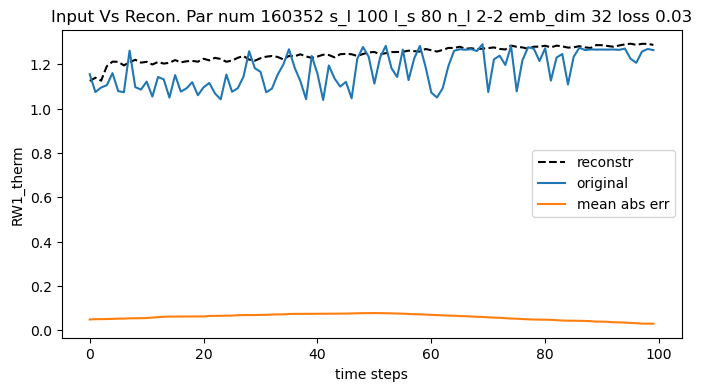

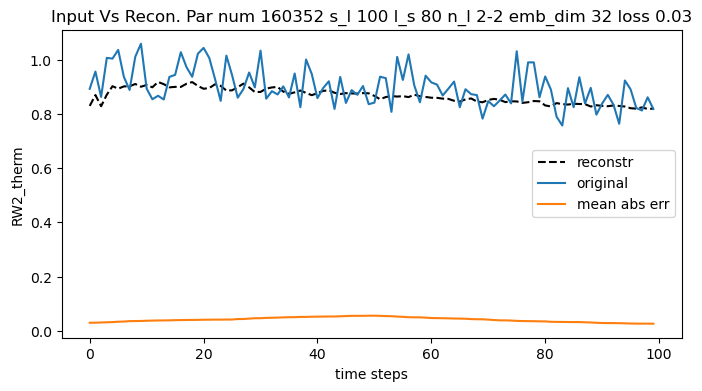

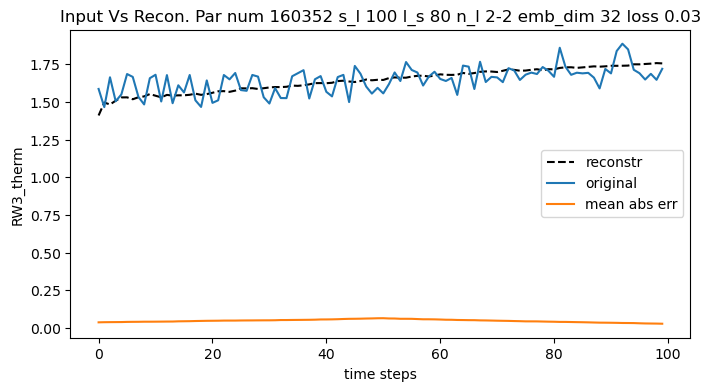

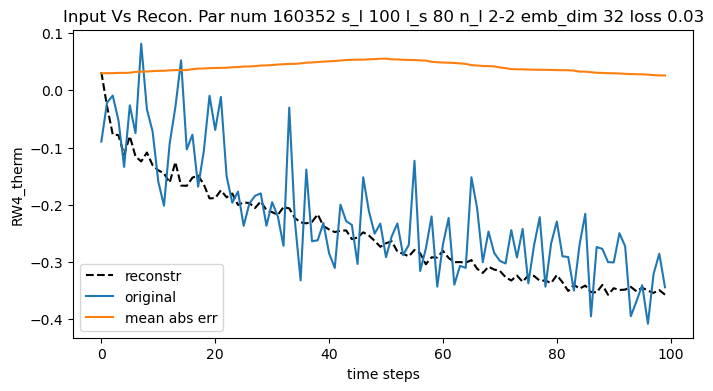

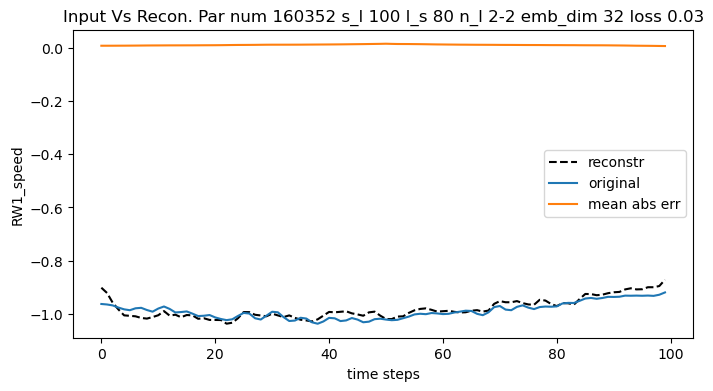

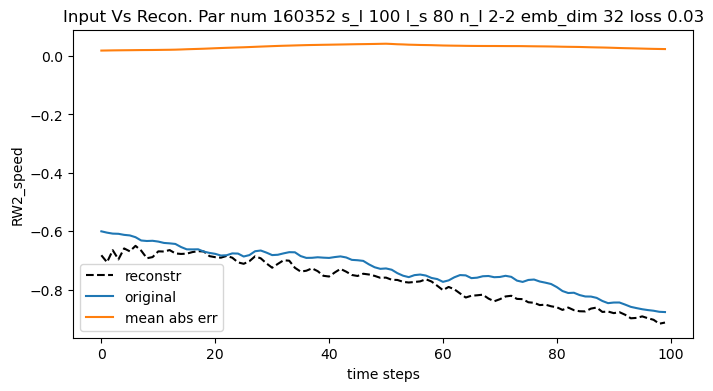

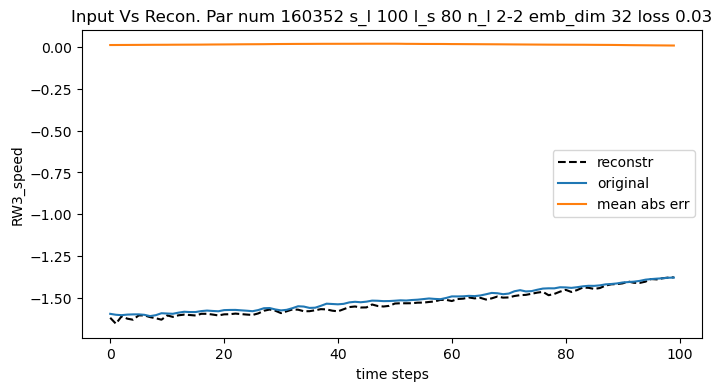

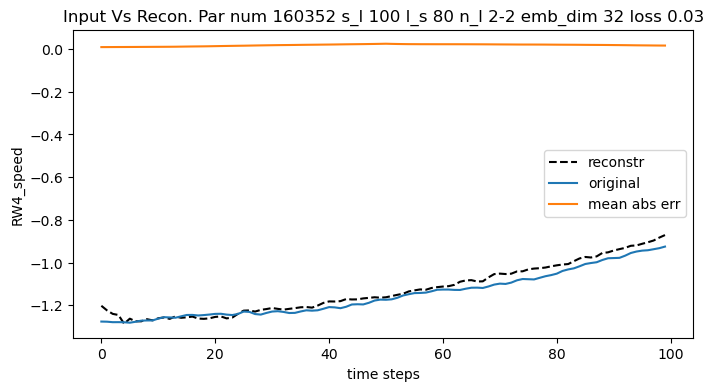

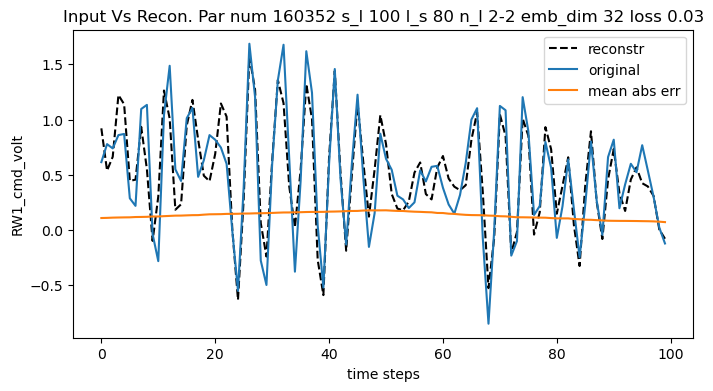

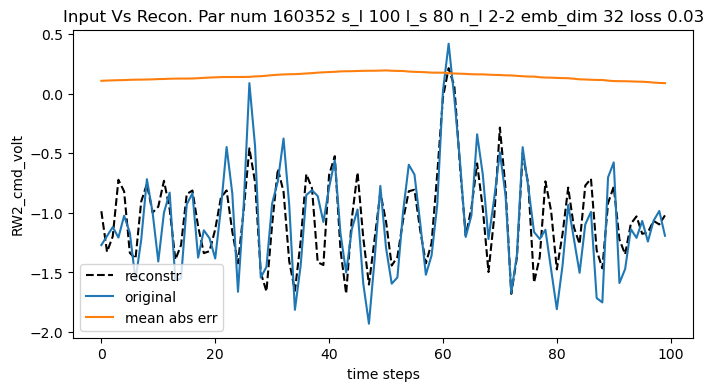

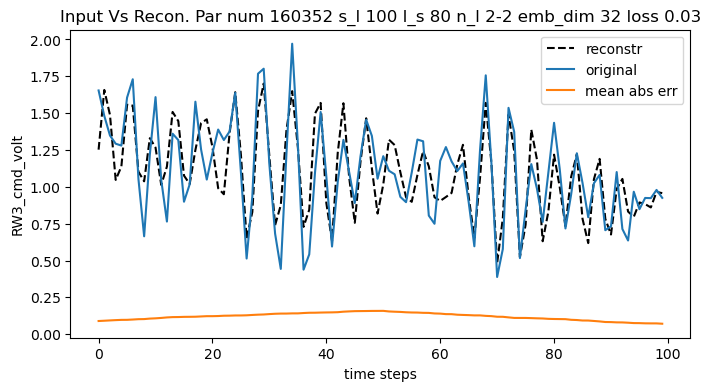

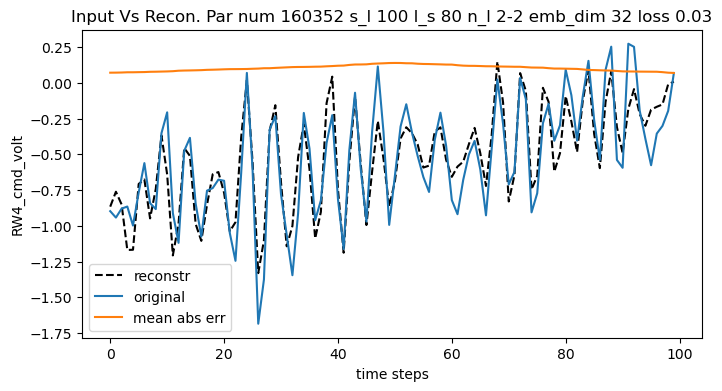

In [60]:
for i in range(x.shape[2]):
    fig, ax = plt.subplots(1,1, figsize=(8,4))

    ax.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), 
               linestyle='--', label='reconstr', color='black')
    ax.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy(), label ='original')
    x_i = x.flatten(0,1)[:,i]
    y_o = yo.flatten(0,1)[:,i]

    loss_u = torch.nn.L1Loss(reduction='none')(y_o, x_i)
    loss_u = moving_average(loss_u.to("cpu").detach().numpy(), params_conf['sequence_length'])

    ax.plot(loss_u, label ='mean abs err')
    ax.set_xlabel('time steps')
    ax.set_ylabel('{}'.format(cfg['dataset']['columns'][i]))
    try:
        ax.set_title('Input Vs Recon. Par num {} s_l {} l_s {} n_l {}-{} emb_dim {} loss {}'\
                        .format(par_nums, params_conf['sequence_length'], 
                                params_conf['latent_dim'], params_conf['n_layers'],params_conf['n_layers'],
                                params_conf['embedding_dim'],
                                np.round(checkpoint['loss'],2)))    
    except:
        ax.set_title('Input Vs Recon. Par num {} s_l {} l_s {} n_l {}-{} emb_dim {} loss {}'\
                        .format(par_nums, params_conf['sequence_length'], 
                                params_conf['latent_dim'], params_conf['n_layers_1'],params_conf['n_layers_2'],
                                params_conf['embedding_dim'],
                                np.round(checkpoint['loss'],2)))    
        
    ax.legend()
    if save:
        os.makedirs(path, exist_ok=True)
        plt.savefig(path + '{}_shift_{}_{}_batch_{}.png'.format(cfg['dataset']['columns'][i],shift,i, num_batch))

### Anomaly section

NameError: name 'ya' is not defined

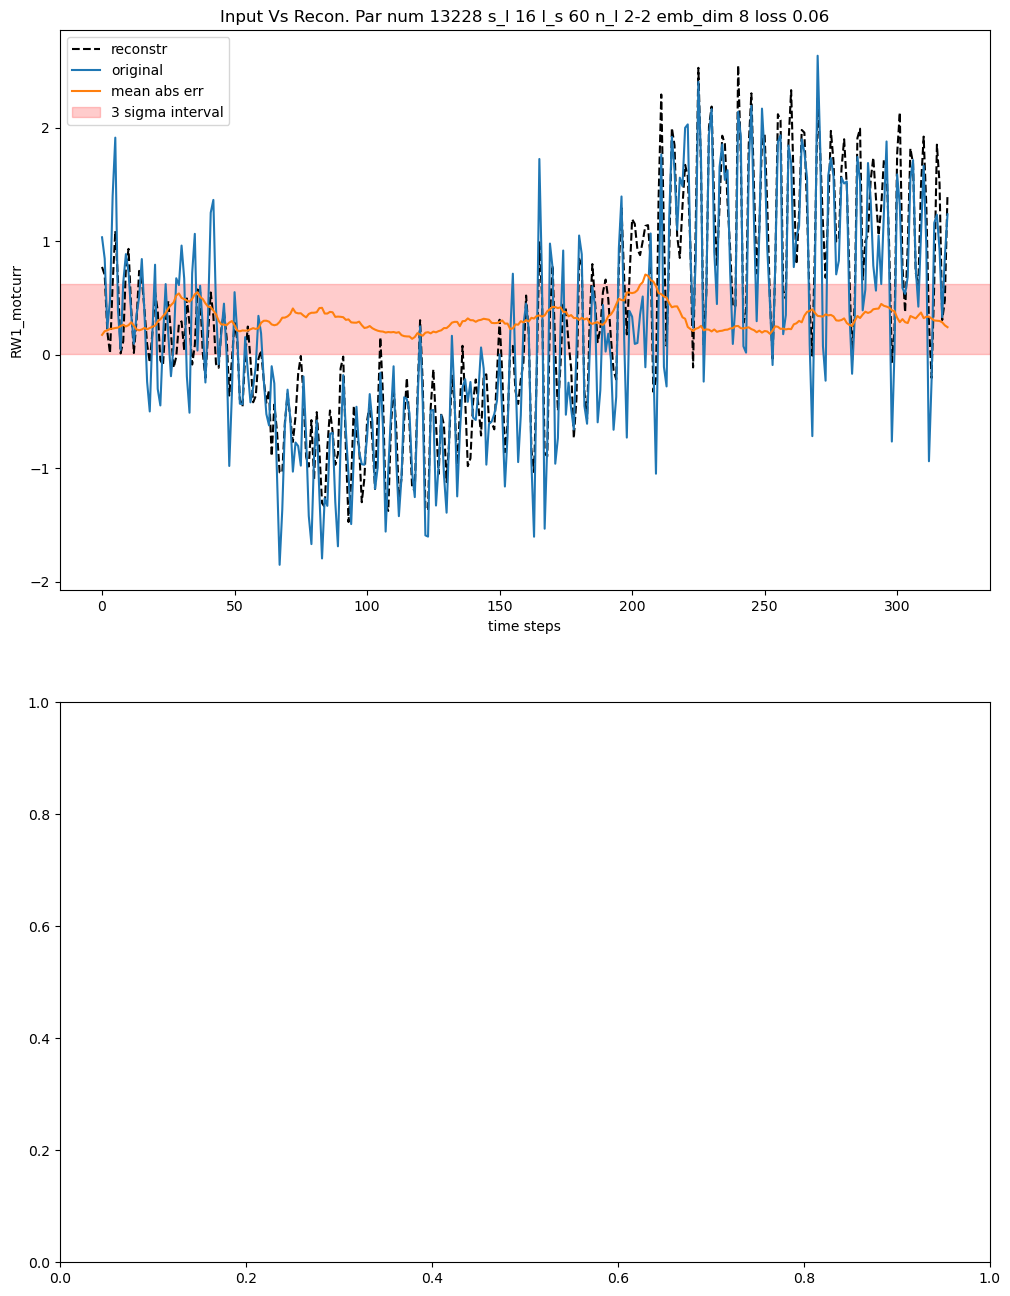

In [29]:
for i in range(x.shape[2]):
    fig, ax = plt.subplots(2,1, figsize=(12,16))

    ax[0].plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), 
               linestyle='--', label='reconstr', color='black')
    ax[0].plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy(), label ='original')
    x_i = x.flatten(0,1)[:,i]
    y_o = yo.flatten(0,1)[:,i]

    loss_u = torch.nn.L1Loss(reduction='none')(y_o, x_i)
    loss_u = moving_average(loss_u.to("cpu").detach().numpy(), seq_len)

    ax[0].plot(loss_u, label ='mean abs err')
    ax[0].set_xlabel('time steps')
    ax[0].set_ylabel('{}'.format(cols[i]))
    ax[0].set_title('Input Vs Recon. Par num {} s_l {} l_s {} n_l {}-{} emb_dim {} loss {}'\
                    .format(par_nums, seq_len, 
                            latent_dim, params_conf['n_layers'],params_conf['n_layers'],
                            params_conf['embedding_dim'],
                            np.round(checkpoint['loss'],2)))
    #ax[0].hlines(np.mean(loss_u), 0, len(x_i), colors='green')
    ax[0].axhspan(np.mean(loss_u)-3*np.std(loss_u),
                  np.mean(loss_u)+3*np.std(loss_u)
                  , alpha=0.2, color='red', label='3 sigma interval')

    
    #ax[0].axhspan(np.mean(filtered)-3*np.std(loss_u),
    #              np.mean(loss_u)+3*np.std(loss_u)
    #              , alpha=0.2, color='green', label='3 sigma interval without anomaly')
    
    ax[0].legend()


    ax[1].plot(ya.flatten(0,1)[:,i].to("cpu").detach().numpy(), 
               linestyle='--', label='reconstr', color='black')
    ax[1].plot(xa.flatten(0,1)[:,i].to("cpu").detach().numpy(), label ='original')

    x_i = xa.flatten(0,1)[:,i]
    y_o = ya.flatten(0,1)[:,i]

    loss_u = torch.nn.L1Loss(reduction='none')(y_o, x_i)
    loss_u = moving_average(loss_u.to("cpu").detach().numpy(), seq_len)
    filtered = np.concatenate((loss_u[0:(batch[0])*seq_len], loss_u[(batch[0]+1)*seq_len:]))

    #y_test = x_i[(batch[0])*seq_len:(batch[0]+1)*seq_len].to("cpu").detach().numpy()
    #pred = y_o[(batch[0])*seq_len:(batch[0]+1)*seq_len].to("cpu").detach().numpy()
    #mape = np.mean(np.abs((y_test - pred) / y_test))

    ax[1].plot(loss_u, label ='mean abs err')
    ax[1].set_xlabel('time steps')
    ax[1].set_ylabel('{}'.format(cols[i]))
    ax[1].set_title('Injected anom. on {}'\
                    .format(cols[feats[0]]))
                           #,mape
                           #,loss))

    ax[1].axvspan((batch[0])*seq_len, (batch[0]+1)*seq_len, alpha=0.2, color='red')
    #ax[1].hlines(np.mean(loss_u), 0, len(x_i), colors='green', label = 'anom seq in {} with {} sigma deviation'\
    #             .format(feats[0], sigma))
    ax[1].axhspan(np.mean(loss_u)-3*np.std(loss_u),
                  np.mean(loss_u)+3*np.std(loss_u), alpha=0.2, color='red', label='3 sigma interval')
        
    ax[1].axhspan(np.mean(filtered)-3*np.std(filtered),
                  np.mean(filtered)+3*np.std(filtered)
                  , alpha=0.2, color='green', label='3 sigma interval without anomaly')
    ax[1].legend()

    if save:
        os.makedirs(path, exist_ok=True)
        plt.savefig(path + '{}_shift_{}_{}_sigma_{}_batch_{}.png'.format(cols[i],shift,sigma,i, num_batch))


In [ ]:
cols = checkpoint['cfg']['dataset']['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']
shuffle = cfg['dataset']['shuffle']
columns_subset = cfg['dataset']['columns_subset']
dataset_subset = cfg['dataset']['dataset_subset']
dataset_subset = cfg['dataset']['dataset_subset']
train_val_split = cfg['dataset']['train_val_split']
target = cfg['dataset']['target']

latent_dim = params_conf['latent_dim']
par_nums = checkpoint['parameters_number']
seq_len = params_conf['sequence_length']